
## Задание
    
1. Возьмите англо-русскую пару фраз (www.manythings.org....org/anki/).
2. Обучите на них seq2seq по аналогии с занятием. Оцените полученное качество.
3. Попробуйте добавить +1 рекуррентный слой в encoder и decoder.
4. Попробуйте заменить GRU ячейки на lstm-ячейки.<br>
   Оцените качество во всех случаях.

5. Добавит в лекционный ноутбук, в функцию train, обучение батчами.

In [1]:
%matplotlib inline

In [2]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [3]:
# загрузка данных. пары предложений на разных языках.

# если данные уже загружены, то повторно загружать не нужно, поэтому закомментировал

# !wget https://download.pytorch.org/tutorial/data.zip
# !unzip data.zip

In [4]:
# англо-русский текст с предложениями, разделёнными табуляцией
!tail ../../Материалы/rus-eng/eng-rus.txt

We need to uphold laws against discrimination — in hiring, and in housing, and in education, and in the criminal justice system. That is what our Constitution and our highest ideals require.	Нам нужно отстаивать законы против дискриминации при найме на работу, в жилищной сфере, в сфере образования и правоохранительной системе. Этого требуют наша Конституция и высшие идеалы.	CC-BY 2.0 (France) Attribution: tatoeba.org #5762728 (BHO) & #6390439 (odexed)
I've heard that you should never date anyone who is less than half your age plus seven. Tom is now 30 years old and Mary is 17. How many years will Tom need to wait until he can start dating Mary?	Я слышал, что никогда не следует встречаться с кем-то вдвое младше вас плюс семь лет. Тому 30 лет, a Мэри 17. Сколько лет Тому нужно ждать до тех пор, пока он сможет начать встречаться с Мэри?	CC-BY 2.0 (France) Attribution: tatoeba.org #10068197 (CK) & #10644473 (notenoughsun)
I do have one final ask of you as your president, the same thing I a

##### создание класса для предподготовки текста

In [5]:
# подготавливаем текст. его нужно токенизировать. работать будем с грануляцией на уровне слов.
# для этого создаём класс

# создаём токены начала и конца предложения
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name                            # название языка
        self.word2index = {}                        # словарь слово в индекс
        self.word2count = {}                        # словарь слово и количество применений
        self.index2word = {0: "SOS", 1: "EOS"}      # словарь индекс в слово
        self.n_words = 2  # Count SOS and EOS       # текущее количество уникальных слов

    def addSentence(self, sentence): # функция разделяет предложение на токены по пробелам и передаёт слова в функцию addWord
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):                        # функция добавления слова в словарь
        if word not in self.word2index:             # если слова нет в словаре
            self.word2index[word] = self.n_words    # добавляет слово в словарь, слово - ключ, текущее кол-во слов в словаре - значение, т.е.индекс данного слова
            self.word2count[word] = 1               # обновляет количество повторений таких слов в словаре
            self.index2word[self.n_words] = word    # обновляет обратный словарь - индекс данного слова - ключ, само слово - значение
            self.n_words += 1                       # обновляет количество уникальных слов в словаре
        else:                                       # если слово есть в словаре
            self.word2count[word] += 1              # обновляет количество повторений таких слов в словаре

##### вспомогательная функция для удаления лишних символов и перевода символов unicode в обычные символы

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):                               # переводит unicode в обычные символы
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())   # переводит в ascii, в нижний регистр, обрезает пробелы
    s = re.sub(r"([.!?])", r" \1", s)       # вставляет пробел межды символами ".!?"
    s = re.sub(r"[^a-zа-яё.!?]+", r" ", s)   # меняет все остальные символы на пробел
    return s

##### вспомогательная функция для определения языков перевода и формирования пар предложений

In [7]:
def readLangs(lang1, lang2, reverse=False):                              # принимает названия языков
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('../../Материалы/rus-eng/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')                                       # открывает файл с соответствующим названием, разделяем строки

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[0:2]] for l in lines] # каждую строку разделяет по табуляции и применяет нормализацию
                                                                         # на выходе выдаёт список списков пар предложений
                                                                         # ограничиваем первыми двумя параметрами, третий исключаем
    # Reverse pairs, make Lang instances
    if reverse:                                     # определяет входной и выходной языки
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

##### вспомогательная функция для ограничения длины предложения и фильтрации пар

In [8]:
MAX_LENGTH = 10                     # максимальная длина предложения в токенах = 10

eng_prefixes = (                    # английские предложения могут начинаться только с таких токенов
    "i ", 
    "he ", 
    "she ", 
    "you ", 
    "we ", 
    "they ",
    "if",
    "since",
    "at",
    "when"
)


def filterPair(p):                                  # функция фильтрации пар, проверяет длину каждого предложения
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)               # переводим с фр. на анг. поэтому проверяем префиксы второго языка - английского


def filterPairs(pairs):                             # функция прогоняет пары через предыдущую функцию
    return [pair for pair in pairs if filterPair(pair)]

##### финальная функция для подготовки данных

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse) # запускает функцию readLangs, выдаёт два языка и список списов пар
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)                                        # фильтрует пары
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:                                                # заполняет словари входными и выходными предложениями
        input_lang.addSentence(pair[0])                               
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 487600 sentence pairs
Trimmed to 160246 sentence pairs
Counting words...
Counted words:
rus 27477
eng 9148
['он был полностью поглощен книгои .', 'he was completely engrossed in the book .']


## The Encoder

##### класс энкодекра - обычная RNN с ячейкой GRU

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):  # на вход принимает размер входа (словаря), размер скрытого состояния и количество слоёв
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size                          # скрытое состояние сохраняется внутри модели
        self.num_layers=num_layers                              # добавляю количество слоёв

        self.embedding = nn.Embedding(input_size, hidden_size)  # создаётся слой эмбеддингов
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers) # рекурренитный слой на основе ячейки GRU, который принимает и выдаёт скрытое состояние

    def forward(self, input, hidden):                           # на вход принимает одно слово и скрытое состояние
        embedded = self.embedding(input).view(1, 1, -1)         # пропускаем слово через эмбеддинги, делаем view для правильного отображения (добавляем 2 пустых слоя)
        output = embedded                                       # приравниваем эмбеддинги к output'ам
        output, hidden = self.gru(output, hidden)               # передаём output и скрытое состояние в рекуррентный слой
        return output, hidden

    def initHidden(self):                                       # сбрасывает скрытое состояние
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

## The Decoder

##### декодер - почти то же самое, что и энкодер, но с дополнительными слоями для нормального выхода

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.out = nn.Linear(hidden_size, output_size)          # линейный слой для приведения размера скрытого состояния к размеру выходного словаря
        self.softmax = nn.LogSoftmax(dim=1)                     # распределение вероятности с помощью функции softmax     

    def forward(self, input, hidden):                           # на вход принимает одно слово и скрытое состояние
        output = self.embedding(input).view(1, 1, -1)           # пропускаем слово через эмбеддинги, делаем view для правильного отображения (добавляем 2 пустых слоя)
        output = F.relu(output)                                 # пропускаем его через relu, однако здесь это не имеет особого смысла, т.к. в дальнейшем может сбится
        output, hidden = self.gru(output, hidden)               # передаём output и скрытое состояние в рекуррентный слой
        output = self.softmax(self.out(output[0]))              # т.к. выход - одно слово - здесь захардкожен 0, который пропускаем через линейный и softmax слои
        return output, hidden                                   # на выходе получаем распределение вероятности и скрытое состояние

    def initHidden(self):                                       # сбрасывает скрытое состояние
        return torch.zeros(num_layers, 1, self.hidden_size, device=device)

##### вспомогательные функции для перевода предложений в тензоры

In [12]:
def indexesFromSentence(lang, sentence):                            # переводит слова в предложении в индексы слов
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):                             # переводит индексы слов в тензоры
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)                                       # добавляет к индексам токен конца предложения
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1) # переводит индексы в тензор нужного размера


def tensorsFromPair(pair):                                          # переводит пары в тензоры
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

##### функция обучения на одном предложении

In [13]:
teacher_forcing_ratio = 0.5 # вероятность использования teacher forcing


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()           # сбрасывает скрытое состояние энкодера

    encoder_optimizer.zero_grad()                   # сбрасывает градиенты
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)             # фиксирует длину входной последовательности
    target_length = target_tensor.size(0)           # фиксирует длину выходной последовательности

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device) # это будет использовано на след. занятии для механизма внимания
                                                                                  # пока заполняем нулями
    loss = 0                                        # устанавливаем лосс = 0

    for ei in range(input_length):                  # проходимся по длине предложения
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden) # передаём в encoder слово и скрытое состоние для всех слов в предложении
        encoder_outputs[ei] = encoder_output[0, 0]             # кладём выходы модели в соответствующее место выходов по индексу

    decoder_input = torch.tensor([[SOS_token]], device=device) # создаём входную цепочку для decoder, первым кладём туда токен начала предложения

    decoder_hidden = encoder_hidden                            # передаём скрытое представление из энкодера в декодер приравняв одно к другому

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False    # определяем использование путём случайной вероятности

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) # аналогично работе энкодера
            loss += criterion(decoder_output, target_tensor[di])                    # считаем и обновляем значение loss
            decoder_input = target_tensor[di]  # Teacher forcing                    # подставляем правильное значение

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) # аналогично работе энкодера

            # для выхода используем жадный алгоритм, который выдаёт top k элементов
            topv, topi = decoder_output.topk(1)      # просим вернуть один элемент с самой большой вероятностью (topv - значение, topi - индекс)
            decoder_input = topi.squeeze().detach()  # убираем из тензора индекса лишние уровни и градиенты

            loss += criterion(decoder_output, target_tensor[di]) # считаем и обновляем значение loss
            if decoder_input.item() == EOS_token:    # если индекс предсказанного токене = EOS, то прекращаем генерацию
                break

    loss.backward()             # считаем градиенты

    encoder_optimizer.step()    # обновляем градиенты в энкодере
    decoder_optimizer.step()    # обновляем градиенты в декодере

    return loss.item() / target_length # выдаёт лосс нормированный на длину последовательности

##### вспомогательные функции для работы со временем, на лекции не разбирали

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)                               # округление вниз
    s -= m * 60                                          # вычитает из секунд минуты
    return '%dm %ds' % (m, s)                            # возвращает время в минутах и секундах


def timeSince(since, percent):                           # рассчитывает время до конца обучения
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

##### функция обучения модели, использует функцию обучения на одном предложении выше

In [15]:
p_l = []
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    # принимает на вход:
    # encoder                   - энкодер
    # decoder                   - декодер
    # n_iters                   - количество итераций
    # print_every=1000          - количекство итерация для печати результатов
    # plot_every=100            - количество итерация для вывода графика
    # learning_rate=0.01        - learning rate

    start = time.time()                                                                 # время начала обучения
    plot_losses = []                                                                    # список лоссов для графика
    plot_acc = []                                                                       # список точности для графика
    print_loss_total = 0  # Reset every print_every                                     # сбрасывает значение счётчика лосс для печати
    print_acc_total = 0                                                                 # сбрасывает значение счётчика точности для печати
    plot_loss_total = 0  # Reset every plot_every                                       # сбрасывает значение счётчика лосс для графика
    plot_acc_total = 0                                                                  # сбрасывает значение счётчика точности для графика

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)               # оптимизатор для энкодера
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)               # оптимизатор для декодера
    training_pairs = [random.choice(pairs) for i in range(n_iters)]                     # отдельно формирую пары для обучения
    training_tensors = [tensorsFromPair(pair) for pair in training_pairs]               # отдельно перевожу их в тензоры
                                                                                        # нужно для расчёта accuracy, скрипт с лекции выдаёт ошибку
     
    # training_pairs = [tensorsFromPair(random.choice(pairs))                           # формирует случайные пары для обучения
                    #   for i in range(n_iters)]
    criterion = nn.NLLLoss()                                                            # функция потерь, негативный алгоритм превдоподобия без softmax
                                                                                        # т.к. softmax уже использовали раньше и второй раз этого делать не нужно
    for iter in range(1, n_iters + 1):                                                  # итерируемся по итерациям
        training_pair = training_tensors[iter - 1]                                        # берём тренировочную пару по номеру итерации
        input_tensor = training_pair[0]                                                 # входное предложение
        target_tensor = training_pair[1]                                                # выходное предложение

        loss = train(input_tensor, target_tensor, encoder,                              # получаем лосс путём запуска функции обучения для одного предложения для
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        # блок для расчёта точности
        input_sentence = training_pairs[iter - 1][0]
        predicted_sentence = ' '.join([word for word in evaluate(encoder, decoder, input_sentence) if word != '<EOS>'])
        predicted_tensor = tensorFromSentence(output_lang, predicted_sentence)
        min_len = min(predicted_tensor.shape[0], target_tensor.shape[0])
        acc = np.mean(predicted_tensor.cpu().numpy()[0:min_len] == target_tensor.cpu().numpy()[0:min_len])
        print_acc_total += acc
        plot_acc_total += acc

        if iter % print_every == 0:                                                     # если итерация соответствует условиям печати
            print_loss_avg = print_loss_total / print_every                             # печатаем средний лосс
            print_loss_total = 0                                                        # обнуляем счётчик
            print_acc_avg = print_acc_total / print_every                               # печатаем среднюю точность
            print_acc_total = 0                                                         # обнуляем счётчик
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),              # печатем результаты
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:                                                      # если итерация соответствует условиям вывода графика
            plot_loss_avg = plot_loss_total / plot_every                                # считаем средний
            plot_losses.append(plot_loss_avg)                                           # обновляем список лосс для графика
            
            plot_loss_total = 0                                                         # обнуляем список
            plot_acc_avg = plot_acc_total / plot_every                                  # считаем среднюю точность
            plot_acc.append(plot_acc_avg)                                               # обновляем список точности для графика
            plot_acc_total = 0                                                          # обнуляем список

    showPlot(plot_losses)                                                               # выводим график
    
    return plot_losses, plot_acc                                                             

##### вспомогательная функция для отрисовки графика

In [16]:
import matplotlib.pyplot as plt
# plt.switch_backend('agg')                            # с этим бекэндом не работает, поэтому отключил
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

##### функция для перевода предложений

In [17]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):                       # на вход принимает энкодер, декодер и предложение, ограничение кол-ва токенов
    with torch.no_grad():                                                              # не учитываем градиенты
        input_tensor = tensorFromSentence(input_lang, sentence)                        # переводим входное предложение в тензор
        input_length = input_tensor.size()[0]                                          # считает длину входного предложения
        encoder_hidden = encoder.initHidden()                                          # обнуляет скрытое состояние

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)  #

        
        for ei in range(input_length):                                                 # итерируемся по длине входного предложения
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden) # пропускаем каждое слово через энкодер
            encoder_outputs[ei] += encoder_output[0, 0]                                # формируем выходы энкодера, хотя для генерации они не нужны

        decoder_input = torch.tensor([[SOS_token]], device=device)                     # создаём тензор для выходного предложения

        decoder_hidden = encoder_hidden                                                # приравниваем скрытое состояние энкодера к декодеру

        decoded_words = []                                                             # список для выходных слов

        for di in range(max_length):                                                   # итерируемся по максимальной длине
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)    # пропускаем вход декодера и скрытое состояние через декодер
            topv, topi = decoder_output.data.topk(1)                                   # получаем значение и индекс максимальной вероятности
            if topi.item() == EOS_token:                                               # если предложение закончилось
                decoded_words.append('<EOS>')
                break
            else:                                                                      # если предложение не закончилось, то 
                decoded_words.append(output_lang.index2word[topi.item()])              # заполняем список словом, полученным из индекса наиболее высокой вероятности

            decoder_input = topi.squeeze().detach()                                    # кладём в decoder_input индекс последнего сгенерированного токена

        return decoded_words

##### функция случайной генерации

In [18]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

##### запускаем обучение

##### 1 рекуррентный слой

In [19]:
# настрока для тренировки и основного обучения
n_iters = 100000
print_every = 5000

6m 32s (- 124m 18s) (5000 5%) 3.9461
12m 47s (- 115m 7s) (10000 10%) 3.4013
19m 1s (- 107m 51s) (15000 15%) 3.0940
25m 17s (- 101m 10s) (20000 20%) 2.9032
31m 35s (- 94m 47s) (25000 25%) 2.7580
37m 55s (- 88m 29s) (30000 30%) 2.6592
44m 14s (- 82m 9s) (35000 35%) 2.5534
50m 39s (- 75m 58s) (40000 40%) 2.4715
57m 9s (- 69m 51s) (45000 45%) 2.3853
63m 40s (- 63m 40s) (50000 50%) 2.3363
70m 3s (- 57m 19s) (55000 55%) 2.3046
76m 11s (- 50m 47s) (60000 60%) 2.2466
82m 18s (- 44m 19s) (65000 65%) 2.2049
88m 27s (- 37m 54s) (70000 70%) 2.1751
94m 31s (- 31m 30s) (75000 75%) 2.1457
100m 41s (- 25m 10s) (80000 80%) 2.1043
106m 47s (- 18m 50s) (85000 85%) 2.1051
112m 58s (- 12m 33s) (90000 90%) 2.0317
119m 4s (- 6m 16s) (95000 95%) 2.0220
125m 13s (- 0m 0s) (100000 100%) 2.0151


<Figure size 640x480 with 0 Axes>

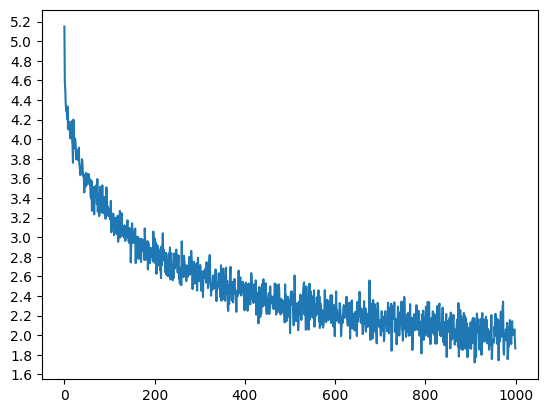

In [20]:
hidden_size = 256                                                   # устанавливаем размер скрытого состояния
encoder1 = EncoderRNN(input_lang.n_words, hidden_size, 1).to(device)   # создаём энкодер
decoder1 = DecoderRNN(hidden_size, output_lang.n_words, 1).to(device)  # создаём денкодер

losses_1, acc_1 = trainIters(encoder1, decoder1, n_iters, print_every)

##### оцениваем результат

In [21]:
evaluateRandomly(encoder1, decoder1)

> я постоянно ношу ботинки .
= i wear boots all the time .
< i ve the the the . <EOS>

> мне сегодня нужно к врачу .
= i have to go to the doctor today .
< i need to get a doctor today . <EOS>

> по вечерам я почти всегда дома .
= i m almost always home in the evenings .
< i m always home at home . <EOS>

> я такого не говорила .
= i said no such thing .
< i didn t show that . <EOS>

> не думаю что они понимали по французски .
= i don t think they could understand french .
< i don t think they can french . <EOS>

> нам деиствительно нужно поговорить .
= we really do need to talk .
< we really need to talk . <EOS>

> он думает я ревную .
= he thinks i m jealous .
< i m the i . . . <EOS>

> вы никогда не должны этого забывать .
= you must never forget that .
< you never never to . <EOS>

> думаю том это сделал .
= i think tom did this .
< i think that tom did that . <EOS>

> не припомню чтобы я вас сюда приглашал .
= i don t remember inviting you here .
< i don t expect you to . . <EOS>


##### 2 рекуррентных слоя

6m 52s (- 130m 36s) (5000 5%) 3.9515
13m 51s (- 124m 46s) (10000 10%) 3.4090
20m 47s (- 117m 49s) (15000 15%) 3.1146
27m 30s (- 110m 3s) (20000 20%) 2.9376
34m 10s (- 102m 31s) (25000 25%) 2.7971
40m 38s (- 94m 50s) (30000 30%) 2.6549
47m 9s (- 87m 34s) (35000 35%) 2.5913
53m 37s (- 80m 26s) (40000 40%) 2.4776
60m 8s (- 73m 30s) (45000 45%) 2.3932
66m 38s (- 66m 38s) (50000 50%) 2.3249
73m 9s (- 59m 51s) (55000 55%) 2.2818
79m 39s (- 53m 6s) (60000 60%) 2.2363
86m 10s (- 46m 24s) (65000 65%) 2.1908
92m 41s (- 39m 43s) (70000 70%) 2.1288
99m 12s (- 33m 4s) (75000 75%) 2.0874
105m 49s (- 26m 27s) (80000 80%) 2.0513
112m 31s (- 19m 51s) (85000 85%) 1.9948
119m 18s (- 13m 15s) (90000 90%) 1.9966
125m 55s (- 6m 37s) (95000 95%) 1.9822
132m 25s (- 0m 0s) (100000 100%) 1.9629


<Figure size 640x480 with 0 Axes>

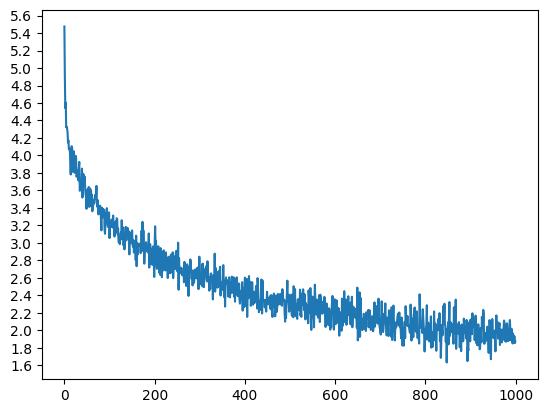

In [22]:
hidden_size = 256                                                   # устанавливаем размер скрытого состояния
encoder2 = EncoderRNN(input_lang.n_words, hidden_size, 2).to(device)   # создаём энкодер
decoder2 = DecoderRNN(hidden_size, output_lang.n_words, 2).to(device)  # создаём денкодер

losses_2, acc_2 = trainIters(encoder2, decoder2, n_iters, print_every)

##### оцениваем результат

In [23]:
evaluateRandomly(encoder2, decoder2)

> мне незачем врать тебе .
= i have no reason to lie to you .
< i m not to to you . . <EOS>

> мне не нравится жить за городом .
= i don t like living in the country .
< i don t like to the the . <EOS>

> мне том никогда особенно не нравился .
= i never really liked tom much .
< i never liked that . <EOS>

> я пыталась быть похожеи на тебя .
= i tried to be like you .
< i tried to be you at . <EOS>

> у меня есть синии новыи велосипед .
= i have a new blue bike .
< i have a new new . . <EOS>

> я даже фамилии его не знаю .
= i don t even know his last name .
< i didn t even know it . <EOS>

> ты знаешь как сильно я ненавижу тома .
= you know how much i hate tom .
< you know how i know tom . <EOS>

> мне просто нужно немного кофе .
= i just need some coffee .
< i just need to get coffee . <EOS>

> я хочу оказаться там первым .
= i want to get there first .
< i want to be there there . <EOS>

> я не одобряю ваше решение .
= i don t approve your decision .
< i m not to your decision . <EO

### Создаю классы encoder и decoder для LSTM

##### в LSTM добавляется cell-state

In [38]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):  # на вход принимает размер входа (словаря), размер скрытого состояния и количество слоёв
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size                          # скрытое состояние сохраняется внутри модели
        self.num_layers=num_layers                              # добавляю количество слоёв

        self.embedding = nn.Embedding(input_size, hidden_size)  # создаётся слой эмбеддингов
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers) # рекурренитный слой на основе ячейки GRU, который принимает и выдаёт скрытое состояние

    def forward(self, input, hidden):                           # на вход принимает одно слово и скрытое состояние
        embedded = self.embedding(input).view(1, 1, -1)         # пропускаем слово через эмбеддинги, делаем view для правильного отображения (добавляем 2 пустых слоя)
        output = embedded                                       # приравниваем эмбеддинги к output'ам
        output, hidden = self.lstm(output, hidden)               # передаём output и скрытое состояние в рекуррентный слой
        return output, hidden

    def initHidden(self):                                       # сбрасывает скрытое состояние
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device), torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [39]:
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)
        self.out = nn.Linear(hidden_size, output_size)          # линейный слой для приведения размера скрытого состояния к размеру выходного словаря
        self.softmax = nn.LogSoftmax(dim=1)                     # распределение вероятности с помощью функции softmax     

    def forward(self, input, hidden):                           # на вход принимает одно слово и скрытое состояние
        output = self.embedding(input).view(1, 1, -1)           # пропускаем слово через эмбеддинги, делаем view для правильного отображения (добавляем 2 пустых слоя)
        output = F.relu(output)                                 # пропускаем его через relu, однако здесь это не имеет особого смысла, т.к. в дальнейшем может сбится
        output, hidden = self.lstm(output, hidden)               # передаём output и скрытое состояние в рекуррентный слой
        output = self.softmax(self.out(output[0]))              # т.к. выход - одно слово - здесь захардкожен 0, который пропускаем через линейный и softmax слои
        return output, hidden                                   # на выходе получаем распределение вероятности и скрытое состояние

    def initHidden(self):                                       # сбрасывает скрытое состояние
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device), torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

##### запускаем обучение

##### 1 рекуррентный слой

6m 56s (- 131m 53s) (5000 5%) 4.0638
14m 2s (- 126m 23s) (10000 10%) 3.5562
21m 18s (- 120m 42s) (15000 15%) 3.3207
28m 36s (- 114m 24s) (20000 20%) 3.1432
35m 57s (- 107m 51s) (25000 25%) 3.0034
43m 9s (- 100m 42s) (30000 30%) 2.8782
50m 13s (- 93m 16s) (35000 35%) 2.7923
57m 15s (- 85m 53s) (40000 40%) 2.6768
64m 21s (- 78m 39s) (45000 45%) 2.6219
71m 25s (- 71m 25s) (50000 50%) 2.5582
78m 32s (- 64m 15s) (55000 55%) 2.4800
85m 44s (- 57m 9s) (60000 60%) 2.4322
92m 50s (- 49m 59s) (65000 65%) 2.4078
100m 0s (- 42m 51s) (70000 70%) 2.3043
107m 8s (- 35m 42s) (75000 75%) 2.2908
114m 19s (- 28m 34s) (80000 80%) 2.2708
121m 52s (- 21m 30s) (85000 85%) 2.2325
129m 39s (- 14m 24s) (90000 90%) 2.1859
137m 11s (- 7m 13s) (95000 95%) 2.1409
144m 24s (- 0m 0s) (100000 100%) 2.1293


<Figure size 640x480 with 0 Axes>

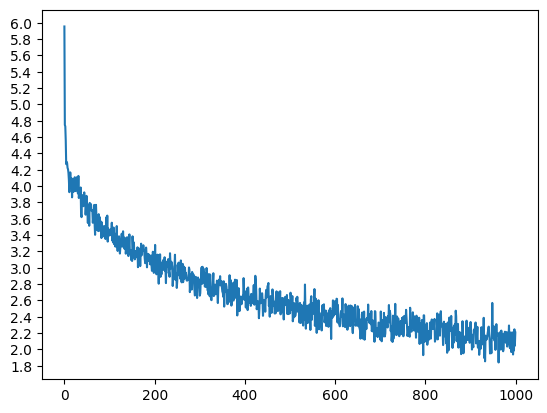

In [40]:
hidden_size = 256                                                   # устанавливаем размер скрытого состояния
encoder3 = EncoderLSTM(input_lang.n_words, hidden_size, 1).to(device)   # создаём энкодер
decoder3 = DecoderLSTM(hidden_size, output_lang.n_words, 1).to(device)  # создаём денкодер

losses_3, acc_3 = trainIters(encoder3, decoder3, n_iters, print_every)

##### оцениваем результат

In [41]:
evaluateRandomly(encoder3, decoder3)

> я много о вас слышал .
= i ve heard a lot about you .
< i ve heard you lot . <EOS>

> теперь я к тому привык .
= i m used to tom now .
< i m tom tom to now . <EOS>

> у меня кран протекает .
= i have a leaky faucet .
< i have a . . . <EOS>

> я уснул читая .
= i fell asleep while reading .
< i was born in the house . <EOS>

> ты можешь отказаться .
= you may refuse .
< you can stop . <EOS>

> он лишен человеческих эмоции .
= he is devoid of human feeling .
< he is a of of . . <EOS>

> думаю никого нет дома .
= i think nobody s home .
< i think that ll stay home home . <EOS>

> надеюсь экзамен будет легкии .
= i hope that the exam will be easy .
< i hope that ll ll be a . . .

> я просто поеду один .
= i ll just go alone .
< i m just tired of . <EOS>

> они не могут этого сделать .
= they can t do this .
< they can t do that . . <EOS>



##### 2 рекуррентных слоя

8m 14s (- 156m 28s) (5000 5%) 4.1803
16m 38s (- 149m 44s) (10000 10%) 3.6949
25m 7s (- 142m 20s) (15000 15%) 3.4558
33m 42s (- 134m 50s) (20000 20%) 3.2748
42m 10s (- 126m 32s) (25000 25%) 3.1155
50m 36s (- 118m 5s) (30000 30%) 3.0049
59m 7s (- 109m 48s) (35000 35%) 2.9169
67m 34s (- 101m 22s) (40000 40%) 2.8327
76m 12s (- 93m 8s) (45000 45%) 2.7560
84m 54s (- 84m 54s) (50000 50%) 2.6452
93m 36s (- 76m 35s) (55000 55%) 2.5863
102m 15s (- 68m 10s) (60000 60%) 2.5040
110m 43s (- 59m 37s) (65000 65%) 2.4511
119m 14s (- 51m 6s) (70000 70%) 2.3985
127m 43s (- 42m 34s) (75000 75%) 2.3730
136m 12s (- 34m 3s) (80000 80%) 2.3241
144m 45s (- 25m 32s) (85000 85%) 2.2527
153m 11s (- 17m 1s) (90000 90%) 2.2303
161m 41s (- 8m 30s) (95000 95%) 2.1715
170m 12s (- 0m 0s) (100000 100%) 2.1308


<Figure size 640x480 with 0 Axes>

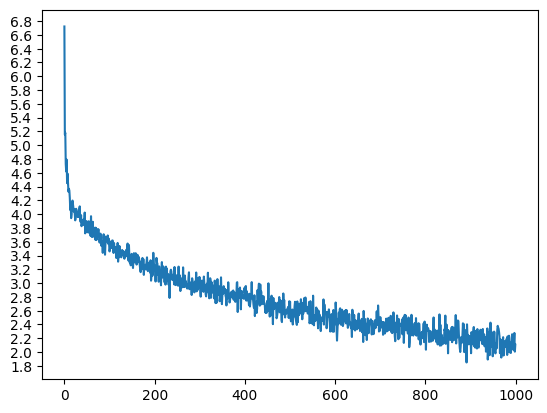

In [42]:
hidden_size = 256                                                   # устанавливаем размер скрытого состояния
encoder4 = EncoderLSTM(input_lang.n_words, hidden_size, 2).to(device)   # создаём энкодер
decoder4 = DecoderLSTM(hidden_size, output_lang.n_words, 2).to(device)  # создаём денкодер

losses_4, acc_4 = trainIters(encoder4, decoder4, n_iters, print_every)

##### оцениваем результат

In [43]:
evaluateRandomly(encoder4, decoder4)

> думаю тебе понравится этот роман .
= i think you ll like this novel .
< i think you ll like this one . <EOS>

> я очень счастлив в бостоне .
= i m very happy in boston .
< i m very happy in boston . <EOS>

> ты сказал что тебе наплевать .
= you said you didn t care .
< you said you said your . <EOS>

> мне нравится быть уборщицеи .
= i like being a janitor .
< i like your way . <EOS>

> сегодня после уроков я буду занята .
= i ll be busy after school today .
< i m be busy with tom . <EOS>

> я редко опаздываю .
= i m seldom late .
< i ve lost a . <EOS>

> я разнервничался .
= i got nervous .
< i m a . <EOS>

> я молода и невинна .
= i m young and innocent .
< i m tired and . <EOS>

> я передумал .
= i ve changed my mind .
< i m a . <EOS>

> я попил молока .
= i drank some milk .
< i m a . . <EOS>



### Строю графики для сравнения моделей

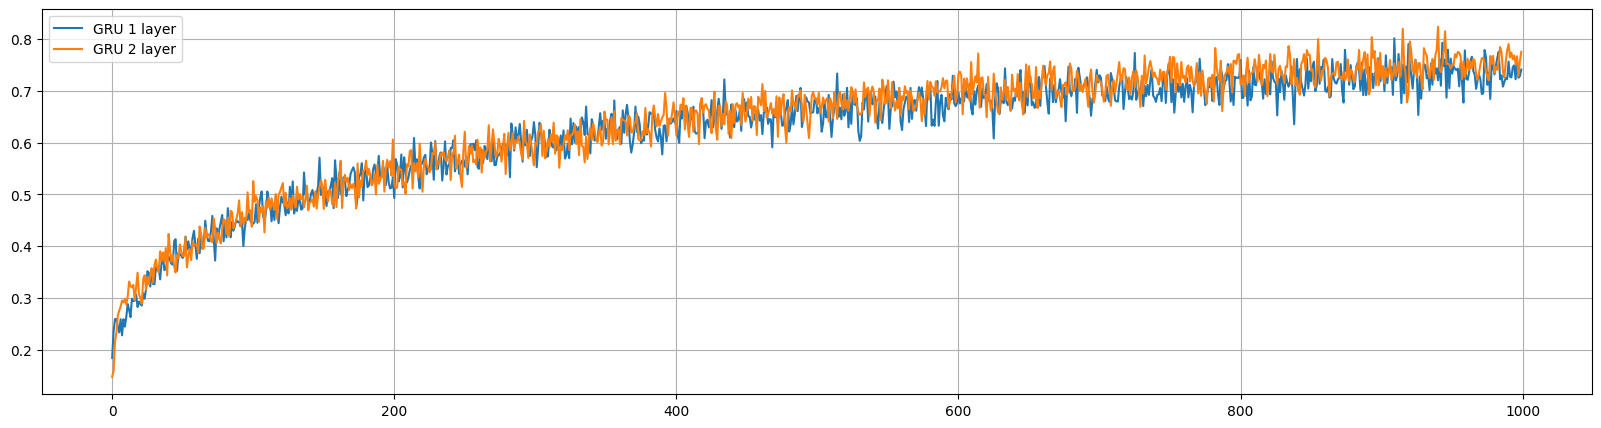

In [44]:
plt.figure(figsize=(20, 5))
plt.plot(acc_1, label='GRU 1 layer')
plt.plot(acc_2, label='GRU 2 layer')
plt.grid()
plt.legend()
plt.show()

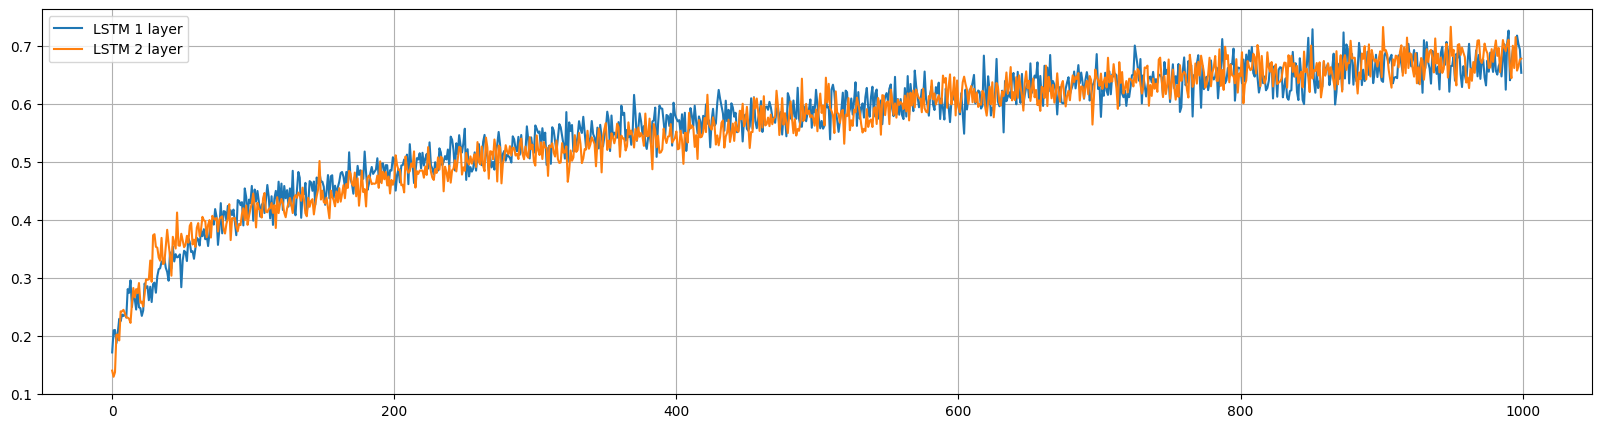

In [45]:
plt.figure(figsize=(20, 5))
plt.plot(acc_3, label='LSTM 1 layer')
plt.plot(acc_4, label='LSTM 2 layer')
plt.grid()
plt.legend()
plt.show()

### Выводы

##### В целом нейросети на GRU показали accuracy около 75%, а LSTM около 67-68%.<br>При этом accuracy у GRU с двумя слоями приблизительно на 3% выше, чем у однослойной сети, а у LSTM разница незаметна.<br>Скорее всего это происходит из-за того, что LSTM лучше работает со сложными последовательностями, а в данном примере предложения короткие и простые.
